# Taller de Futbol Analytics

La idea de este taller es bla bla ... queremos que se lleven bla bla...

In [1]:
# Primero importamos unas librerías de Python que vamos a usar a lo largo del notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV


from adjustText import adjust_text

In [2]:
# Obtenemos los datos desde el archivo df_reducido.csv
df = pd.read_csv("datasets_procesados/df_reducido.csv")

In [3]:
# Podemos obtener una primera visualización de los datos viendo sus primeras 5 filas con el comando head()
display(df.head())

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
0,Vinicius Junior,Real Madrid,La Liga,FW,24,24,1849,11,5,9.6,...,5,7,1,16,0.74,20.5,8,4,68,21
1,Erling Haaland,Manchester City,Premier League,FW,24,28,2480,21,3,20.8,...,11,2,0,24,0.86,27.6,5,1,99,54
2,Lamine Yamal,Barcelona,La Liga,FW,17,27,2236,6,11,7.4,...,12,3,0,17,0.75,24.8,24,12,101,29
3,Jude Bellingham,Real Madrid,La Liga,MF,21,24,1983,8,7,8.9,...,28,3,1,15,0.56,22.0,28,0,44,16
4,Kylian Mbappe,Real Madrid,La Liga,FW,26,28,2420,22,3,20.0,...,3,3,0,25,0.98,26.9,5,2,121,62


Fijense que en los datos que tenemos que tienen solo numeros, hay menos columnas (porque nos quedamos solo con las que tienen números)

In [4]:
# Con este comando podemos ver las columnas (o sea, toda la información que tenemos de cada jugador)
print(list(df.columns))

['Jugador', 'Equipo', 'Competición', 'Posición', 'Edad', 'Partidos', 'Minutos', 'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'ValorMercado', 'PasesCompletados', 'IntentosPase', 'PctPasesCompletados', 'DistanciaTotalPases', 'DistanciaProgresiva', 'PasesClave', 'Entradas', 'Intercepciones', 'Bloqueos', 'TarjetasAmarillas', 'TarjetasRojas', 'Goles_Asistencias', 'xG_xAG', 'Equiv_90min', 'EntradasGanadas', 'AsistDesdeCruzados', 'Tiros', 'TirosAlArco']


También podemos usar gráficos para ver la información de manera más comprimida. Por ejemplo si queremos ver los goles y las asistencias de los jugadores, los podemos poner en un gráfico:

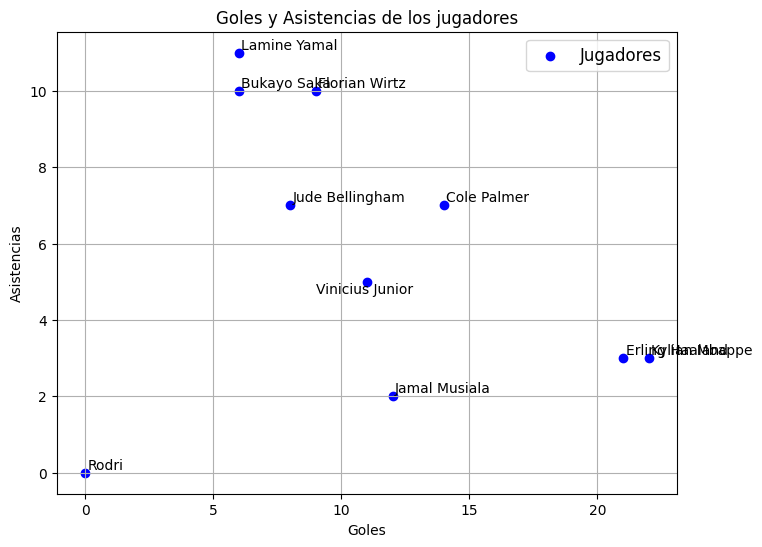

In [5]:
df_grafico=df[:10]
plt.figure(figsize=(8, 6))
plt.scatter(df_grafico['Goles'], df_grafico['Asistencias'], label="Jugadores", color="blue")
plt.text(df_grafico['Goles'][0]-2, df_grafico['Asistencias'][0]-0.3, df["Jugador"][0])
for i in range(1,10):
    plt.text(df_grafico['Goles'][i]+0.1, df_grafico['Asistencias'][i]+0.1, df["Jugador"][i])
plt.xlabel('Goles')
plt.ylabel('Asistencias')
plt.title('Goles y Asistencias de los jugadores')
plt.grid()
plt.legend(fontsize=12)
plt.show()

Se pone divertido cuando podemos ver un monton de estos datos. Podemos buscar relaciones entre las estadísticas de los futbolistas.

Elijamos dos columnas y veamos la relación:

In [6]:
# Acá capaz podrían jugar un poco con esto
primera_columna = 'PasesCompletados' # Pases completados cada 90 minutos
segunda_columna = 'Goles' # Tiros totales cada 90 minutos

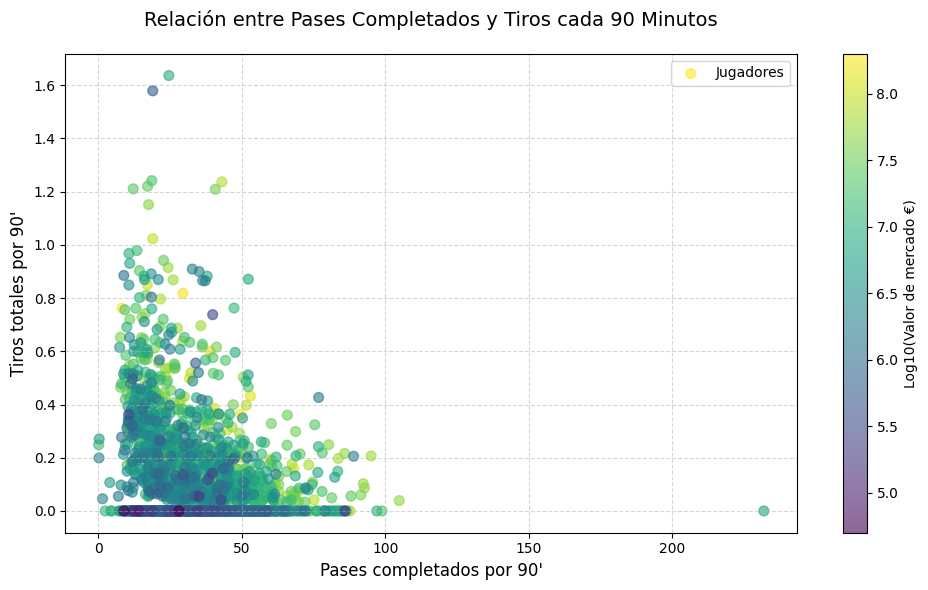

In [7]:
df_grafico = df[df["Minutos"] > 90] # Para el gráfico nos quedamos con los futbolistas que hayan jugado al menos 90 minutos

# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
pases_90 = 90 * df_grafico[primera_columna] / df_grafico['Minutos'] # Cuantos pases hizo cada 90 minutos
tiros_90 = 90 * df_grafico[segunda_columna] / df_grafico['Minutos'] # Cuantos tiros al arco hizo cada 90 minutos

plt.scatter(
    x=pases_90,
    y=tiros_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre Pases Completados y Tiros cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('Pases completados por 90\'', fontsize=12)
plt.ylabel('Tiros totales por 90\'', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

Estuve experimentando con estas cosas. Pero habría que repensar varias cosas, como ponerles nombres más descriptivos a las columnas, hacer gráficos más interesantes, etc

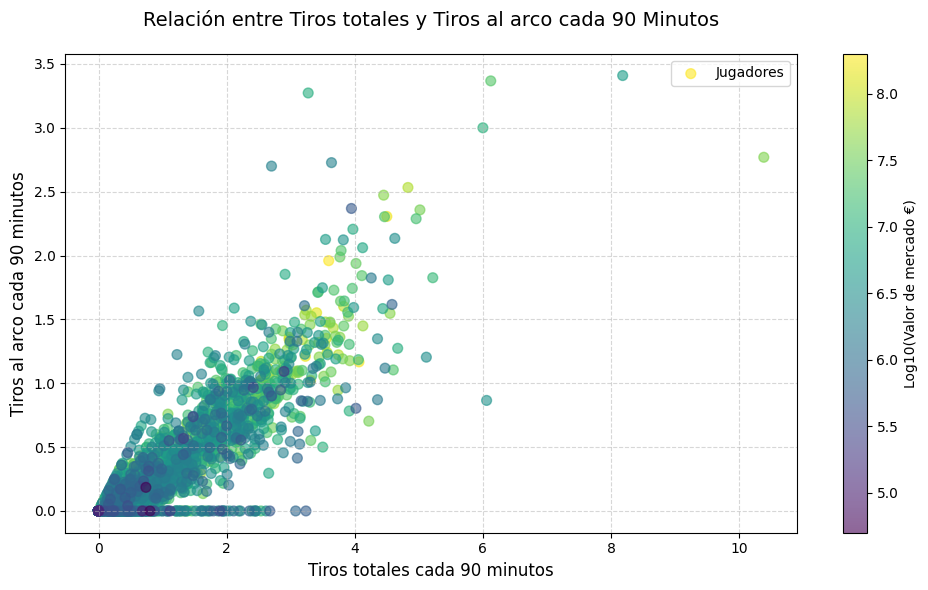

In [8]:
# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
tiros_al_arco_90 = 90 * df_grafico['TirosAlArco'] / df_grafico['Minutos'] # Tiros al arco cada 90 minutos
tiros_90 = 90 * df_grafico['Tiros'] / df_grafico['Minutos']               # Tiros cada 90 minutos

plt.scatter(
    x=tiros_90,
    y=tiros_al_arco_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre Tiros totales y Tiros al arco cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('Tiros totales cada 90 minutos', fontsize=12)
plt.ylabel('Tiros al arco cada 90 minutos', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

Podríamos también experimentar cómo afecta la estadística esta del xG a los goles de un jugaador, veamos qué onda...

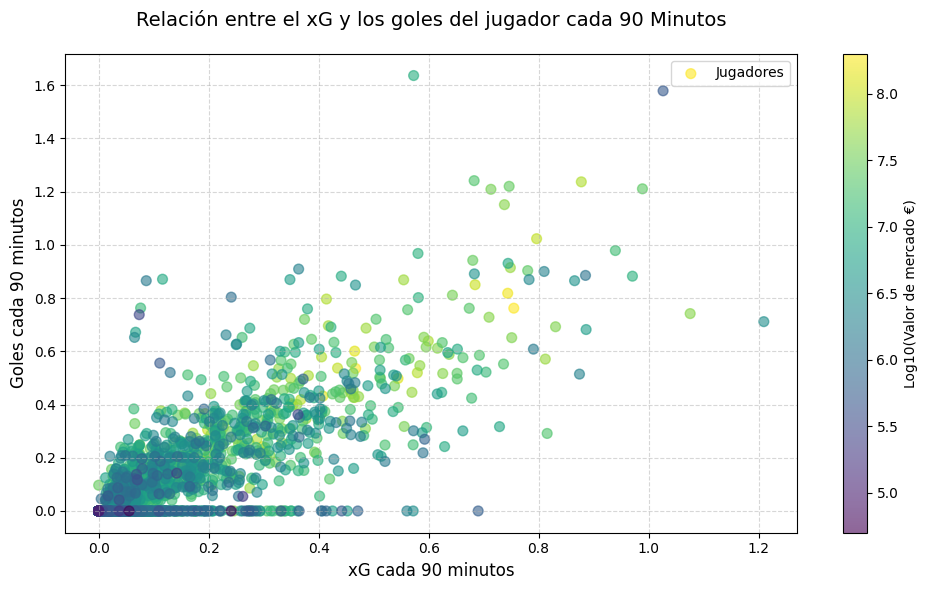

In [9]:
# Configuración de estilo
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Normalizar las métricas por 90 minutos
xG_90 = 90 * df_grafico['xG'] / df_grafico['Minutos']          # xG del jugador cada 90 minutos
goles_90 = 90 * df_grafico['Goles'] / df_grafico['Minutos']    # Goles cada 90 minutos

plt.scatter(
    x=xG_90,
    y=goles_90,
    c=np.log10(df_grafico['ValorMercado']),  # Escala logarítmica base 10
    cmap='viridis',
    alpha=0.6,
    s=50
)
cbar = plt.colorbar()
cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

# Títulos y etiquetas
plt.title('Relación entre el xG y los goles del jugador cada 90 Minutos', fontsize=14, pad=20)
plt.xlabel('xG cada 90 minutos', fontsize=12)
plt.ylabel('Goles cada 90 minutos', fontsize=12)

# Grid y leyenda
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['Jugadores'], loc='upper right')

# Mostrar gráfico
plt.tight_layout()  # Evita cortes en etiquetas
plt.show()

In [10]:
df_grafico[(goles_90>1.4) & (xG_90>1.0)]

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
2224,Noah Edjouma,Toulouse,Ligue 1,"MF,FW",19,7,114,2,0,1.3,...,1,0,0,2,1.01,1.3,2,1,5,3


In [11]:
def df_num_completo(): return pd.read_csv("datasets_procesados/df_num.csv")
def df_num_reducido(): return df.select_dtypes(include=["float64", "int64"])

In [12]:
df_num = df_num_completo()
df_num[df_num.columns] = MinMaxScaler().fit_transform(df_num)

In [13]:
# Definimos una función que nos devuelva, mediante knn, los k jugadores más parecidos para un jugador determinado

def jugadores_parecidos(nombre_jugador, cant_recomendaciones):
    # Obtenemos el índice del jugador
    ind_jugador = df[df["Jugador"]==nombre_jugador].index[0]

    # Inicializamos un NearestNeighbors que busque los n+1 jugadores más parecidos al buscado (porque incluye al jugador buscado)
    neighbors = NearestNeighbors(n_neighbors = cant_recomendaciones + 1).fit(df_num)

    # Obtenemos las distancias a esos jugadores y sus índices
    distances, indices = neighbors.kneighbors(df_num.iloc[[ind_jugador]])

    # Devolvemos el dataset evaluado en esos índices
    res = df.iloc[indices.flatten()]

    # Eliminamos de la lista al mismo jugador
    res = res.drop(ind_jugador, axis=0)
    
    return res

In [14]:
jugadores_parecidos("Lionel Messi", 10)

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
33,Ousmane Dembele,Paris S-G,Ligue 1,FW,27,26,1528,21,5,14.9,...,3,1,0,26,1.29,17.0,5,3,82,43
97,James Maddison,Tottenham,Premier League,MF,28,28,1611,9,5,5.8,...,13,6,0,14,0.52,17.9,16,5,38,17
6,Florian Wirtz,Leverkusen,Bundesliga,"MF,FW",21,25,1876,9,10,8.5,...,23,1,0,19,0.69,20.8,18,6,62,28
16,Alexander Isak,Newcastle Utd,Premier League,FW,25,26,2117,20,5,16.1,...,17,1,0,25,0.85,23.5,5,0,70,32
191,Rayan Cherki,Lyon,Ligue 1,"FW,MF",21,24,1578,7,9,4.5,...,6,3,0,16,0.73,17.5,11,3,33,13
74,Matheus Cunha,Wolves,Premier League,"MF,FW",25,26,2143,13,4,6.7,...,17,3,0,17,0.56,23.8,18,9,86,35
60,Ademola Lookman,Atalanta,Serie A,"FW,MF",27,24,1703,13,5,9.2,...,16,4,0,18,0.76,18.9,13,8,67,28
1179,Alassane Plea,Gladbach,Bundesliga,"MF,FW",32,24,1481,10,4,6.6,...,8,3,0,14,0.57,16.5,3,6,35,10
5,Bukayo Saka,Arsenal,Premier League,"FW,MF",23,18,1338,6,10,5.2,...,16,3,0,16,0.75,14.9,13,10,48,18
39,Marcus Thuram,Inter,Serie A,FW,27,30,2176,14,4,9.8,...,15,1,0,18,0.58,24.2,10,3,64,27


In [15]:
#  Separo las estadísticas según cuales son más relevantes para cada posición

stats_delanteros = [
    'stats_Gls', 'stats_Ast', 'stats_G+A', 'stats_xG', 'stats_npxG', 'stats_xAG',
    'stats_npxG+xAG', 'stats_PrgR', 'shooting_Gls', 'shooting_Sh', 'shooting_SoT',
    'shooting_SoT%', 'shooting_G/Sh', 'shooting_G/SoT', 'shooting_xG',
    'shooting_npxG', 'passing_KP', 'passing_PPA', 'passing_xAG', 'gca_SCA90',
    'gca_GCA90', 'possession_Touches', 'possession_Att Pen', 'possession_PrgC',
    'possession_PrgR', 'market_value_in_eur'
]
stats_mediocampistas = [
    'stats_Ast', 'stats_xAG', 'stats_npxG+xAG', 'stats_PrgP', 'stats_PrgR',
    'passing_Cmp%', 'passing_KP', 'passing_PPA', 'passing_xA', 'passing_TotDist',
    'passing_PrgDist', 'passing_xAG', 'gca_SCA', 'gca_SCA90', 'gca_GCA90',
    'possession_Touches', 'possession_PrgC', 'possession_PrgR', 'defense_Tkl',
    'defense_Int', 'misc_Recov', 'market_value_in_eur'
]
stats_defensores = [
    'defense_Tkl', 'defense_TklW', 'defense_Int', 'defense_Clr', 'defense_Blocks',
    'defense_Err', 'defense_Tkl+Int', 'defense_Lost', 'possession_Touches',
    'possession_Def 3rd', 'possession_Def Pen', 'possession_PrgC',
    'misc_CrdY', 'misc_CrdR', 'misc_OG', 'passing_Cmp%', 'passing_PrgDist',
    'market_value_in_eur'
]
stats_arqueros = [
    'stats_MP', 'stats_Starts', 'playingtime_Min%', 'playingtime_onGA',
    'playingtime_onxGA', 'playingtime_xG+/-', 'playingtime_xG+/-90',
    'misc_CrdY', 'misc_CrdR', 'market_value_in_eur'
]

In [16]:
df = pd.read_csv("datasets_procesados/df.csv")

# Asignamos una única posición por jugador, en caso de que haya más de una
df["stats_Pos"] = df["stats_Pos"].apply(lambda x : x[:2])

# Separamos el dataset en 4, uno por cada posición
df_delanteros = df[df["stats_Pos"] == "FW"]
df_mediocampistas = df[df["stats_Pos"] == "MF"]
df_defensores = df[df["stats_Pos"] == "DF"]
df_arqueros = df[df["stats_Pos"] == "GK"]

In [17]:
def mejores_jugadores(posicion, cantidad):

    #Obs: comparar si realmente vale la pena seleccionar las stats más importantes para cada posición o no
    # Sería cambiando las stats asignadas, por las stats que estan comentadas, y comparar el resultado

    # Decidimos con qué dataframe trabajar según la posición
    if posicion == "delanteros":
        df_pos = df_delanteros
        #stats = stats_delanteros
        stats = df_num.columns
    elif posicion == "mediocampistas":
        df_pos = df_mediocampistas
        #stats = stats_mediocampistas
        stats = df_num.columns
    elif posicion == "defensores":
        df_pos = df_defensores
        #stats = stats_defensores
        stats = df_num.columns
    elif posicion == "arqueros":
        df_pos = df_arqueros
        #stats = stats_arqueros
        stats = df_num.columns

    # Aplicamos Z-Score a las columnas
    df_pos_zcores = df_pos[stats].apply(zscore)

    # Calculamos el puntaje total sumando los Z-Scores de cada estadística, ya que todas las columnas son positivas
    df_pos_zcores["score"] = df_pos_zcores.sum(axis=1)

    # Ordenamos el dataframe por el puntaje total
    df_pos_zcores = df_pos_zcores.sort_values(by="score", ascending=False)

    # Ordenamos el dataframe original por el puntaje total
    mejores_jugadores = df_pos_zcores.head(cantidad)

    # Devolvemos el dataframe original con los mejores jugadores
    return df.iloc[mejores_jugadores.index]

In [18]:
# 11 ideal según estadísticas
# Formación: 4-3-3

display(
    mejores_jugadores("delanteros", 3),
    mejores_jugadores("mediocampistas", 3),
    mejores_jugadores("defensores", 4),
    mejores_jugadores("arqueros", 1)
)

#Obs: El dataset que conseguimos, no tiene estadísticas específicas de los arqueros (paradas, arcos en 0, penales atajados, etc.)
#      lo cual explica por qué el resultado no es el Dibu Martínez.

,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,first_name,last_name,full_name,market_value_in_eur,highest_market_value_in_eur
70,Mohamed Salah,eg EGY,FW,Liverpool,Premier League,32,1992,30,30,"2,657",...,0,82,8,9,47.1,NaN,Mohamed Salah,Mohamed Salah,55000000.0,150000000.0
24,Raphinha,br BRA,FW,Barcelona,La Liga,28,1996,28,26,"2,252",...,0,78,6,5,54.5,NaN,Raphinha,Raphinha,80000000.0,80000000.0
2,Lamine Yamal,es ESP,FW,Barcelona,La Liga,17,2007,27,25,"2,236",...,0,96,1,1,50.0,NaN,Lamine Yamal,Lamine Yamal,180000000.0,180000000.0


,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,first_name,last_name,full_name,market_value_in_eur,highest_market_value_in_eur
9,Cole Palmer,eng ENG,MF,Chelsea,Premier League,22,2002,29,29,"2,530",...,0,83,1,5,16.7,Cole,Palmer,Cole Palmer,130000000.0,130000000.0
80,Bruno Fernandes,pt POR,MF,Manchester Utd,Premier League,30,1994,29,29,"2,465",...,0,172,18,25,41.9,Bruno,Fernandes,Bruno Fernandes,55000000.0,90000000.0
6,Florian Wirtz,de GER,MF,Leverkusen,Bundesliga,21,2003,25,20,"1,876",...,0,94,6,32,15.8,Florian,Wirtz,Florian Wirtz,140000000.0,140000000.0


,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,first_name,last_name,full_name,market_value_in_eur,highest_market_value_in_eur
34,Trent Alexander-Arnold,eng ENG,DF,Liverpool,Premier League,26,1998,28,26,"2,145",...,0,120,3,12,20.0,Trent,Alexander-Arnold,Trent Alexander-Arnold,75000000.0,110000000.0
52,Achraf Hakimi,ma MAR,DF,Paris S-G,Ligue 1,26,1998,22,21,"1,826",...,0,124,8,11,42.1,Achraf,Hakimi,Achraf Hakimi,65000000.0,70000000.0
36,Josko Gvardiol,hr CRO,DF,Manchester City,Premier League,23,2002,29,28,"2,557",...,0,116,42,26,61.8,Josko,Gvardiol,Josko Gvardiol,75000000.0,80000000.0
146,Theo Hernandez,fr FRA,DF,Milan,Serie A,27,1997,28,25,"2,254",...,0,111,28,13,68.3,Theo,Hernandez,Theo Hernandez,40000000.0,60000000.0


,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,first_name,last_name,full_name,market_value_in_eur,highest_market_value_in_eur
825,Mark Flekken,nl NED,GK,Brentford,Premier League,31,1993,29,29,"2,555",...,0,35,4,0,100.0,Mark,Flekken,Mark Flekken,10000000.0,12000000.0


In [19]:
df_grafico = df_grafico[df_grafico["Posición"] == "FW"]
df_grafico

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
0,Vinicius Junior,Real Madrid,La Liga,FW,24,24,1849,11,5,9.6,...,5,7,1,16,0.74,20.5,8,4,68,21
1,Erling Haaland,Manchester City,Premier League,FW,24,28,2480,21,3,20.8,...,11,2,0,24,0.86,27.6,5,1,99,54
2,Lamine Yamal,Barcelona,La Liga,FW,17,27,2236,6,11,7.4,...,12,3,0,17,0.75,24.8,24,12,101,29
4,Kylian Mbappe,Real Madrid,La Liga,FW,26,28,2420,22,3,20.0,...,3,3,0,25,0.98,26.9,5,2,121,62
16,Alexander Isak,Newcastle Utd,Premier League,FW,25,26,2117,20,5,16.1,...,17,1,0,25,0.85,23.5,5,0,70,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,Andre Ayew,Le Havre,Ligue 1,FW,35,20,1128,4,1,3.8,...,8,2,0,5,0.31,12.5,9,0,16,7
2191,Christian Gytkjaer,Venezia,Serie A,FW,34,22,363,2,0,1.5,...,1,0,0,2,0.41,4.0,3,0,7,2
2208,Sergi Guardiola,Rayo Vallecano,La Liga,FW,33,12,313,0,0,2.4,...,0,1,0,0,0.72,3.5,2,1,11,3
2213,Jaime Mata,Las Palmas,La Liga,FW,36,22,469,0,0,1.9,...,4,6,0,0,0.40,5.2,1,1,10,3


In [20]:
# Obs: Esta interfaz está muy buena, tendría que ver como sacarle más jugo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Cargar el DataFrame
df_grafico = pd.read_csv("datasets_procesados/df_reducido.csv")

df_grafico = df_grafico[df_grafico["Posición"] == "FW"]

# Filtrar jugadores con más de 90 minutos
df_grafico = df_grafico[df_grafico["Minutos"] > 90]

# Identificar columnas numéricas
numeric_columns = df_grafico.select_dtypes(include=[np.number]).columns

# Crear widgets para seleccionar las columnas
x_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='xG',
    description='Eje X:'
)

y_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='Goles',
    description='Eje Y:'
)

normalizables = [
    'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'Goles_Asistencias', 'xG_xAG',
    'Tiros', 'TirosAlArco', 'PasesClave', 'Entradas', 'Intercepciones', 'Bloqueos',
    'EntradasGanadas', 'AsistDesdeCruzados'
]

# Función para actualizar el gráfico
def update_graph(x_col, y_col):
    plt.figure(figsize=(10, 6))

    # Aplico normalización solo si corresponde
    x_data = df_grafico[x_col]
    y_data = df_grafico[y_col]

    if x_col in normalizables:
        x_data = 90 * x_data / df_grafico['Minutos']
    if y_col in normalizables:
        y_data = 90 * y_data / df_grafico['Minutos']

    # Scatter plot
    plt.scatter(
        x=x_data,
        y=y_data,
        c=np.log10(df_grafico['ValorMercado'] + 1),  # Sumar 1 para evitar log(0)
        cmap='viridis',
        alpha=0.6,
        s=50
    )
    cbar = plt.colorbar()
    cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

    # Etiquetas dinámicas
    x_label = f"{x_col} {'(cada 90 min)' if x_col in normalizables else ''}"
    y_label = f"{y_col} {'(cada 90 min)' if y_col in normalizables else ''}"

    # Títulos y etiquetas
    plt.title(f'{x_col} vs {y_col} para Delanteros', fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Conectar los widgets a la función
ui = widgets.VBox([x_dropdown, y_dropdown])
out = widgets.interactive_output(update_graph, {'x_col': x_dropdown, 'y_col': y_dropdown})

# Mostrar los widgets y el gráfico
display(ui, out)

Output()

In [21]:
df.columns

Index(['Player', 'stats_Nation', 'stats_Pos', 'stats_Squad', 'stats_Comp',
       'stats_Age', 'stats_Born', 'stats_MP', 'stats_Starts', 'stats_Min',
       ...
       'misc_OG', 'misc_Recov', 'misc_Won', 'misc_Lost', 'misc_Won%',
       'first_name', 'last_name', 'full_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object', length=243)

In [22]:
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display

# 1) Cargo datos y normalizo
df = pd.read_csv("datasets_procesados/df_reducido.csv")
df.sort_values("Jugador", inplace=True)

stats = [
    "Goles", "Asistencias", "Tiros", "TirosAlArco", "xG", "xAG",
    "PasesCompletados", "PasesClave", "DistanciaProgresiva", "Entradas", "Intercepciones"
]
df_stats = df[["Jugador"] + stats].dropna()
scaler = MinMaxScaler()
df_stats[stats] = scaler.fit_transform(df_stats[stats])

# 2) Función que extrae lista de valores normalizados
def valores(j):
    return df_stats.loc[df_stats["Jugador"] == j, stats].iloc[0].tolist()

# 3) Jugadores disponibles y valores iniciales
jugadores = df_stats["Jugador"].unique()
j1, j2 = "Lionel Messi", "Raphinha"

# 4) Creo el FigureWidget con dos traces
figw = go.FigureWidget(
    go.Scatterpolar(r=valores(j1), theta=stats, fill="toself", name=j1),
    layout=go.Layout(
        title=f"Comparación: {j1} vs {j2}",
        polar=dict(radialaxis=dict(visible=True, range=[0,1]))
    )
)
# añado el segundo trace
figw.add_trace(go.Scatterpolar(r=valores(j2), theta=stats, fill="toself", name=j2))

# 5) Dropdowns
dd1 = widgets.Dropdown(options=jugadores, value=j1, description="Jugador 1")
dd2 = widgets.Dropdown(options=jugadores, value=j2, description="Jugador 2")

# 6) Función que actualiza traces y título
def actualizar(change):
    # trace 0
    figw.data[0].r = valores(dd1.value)
    figw.data[0].name = dd1.value
    # trace 1
    figw.data[1].r = valores(dd2.value)
    figw.data[1].name = dd2.value
    # título
    figw.layout.title.text = f"Comparación: {dd1.value} vs {dd2.value}"

# conecto listeners
dd1.observe(actualizar, names="value")
dd2.observe(actualizar, names="value")

# 7) Muestro todo
display(widgets.HBox([dd1, dd2]))
display(figw)

FigureWidget({
    'data': [{'fill': 'toself',
              'name': 'Lionel Messi',
              'r': [0.7407407407407407, 0.6470588235294118, 0.6859504132231405,
                    0.6290322580645161, 0.4916666666666667, 0.35714285714285715,
                    0.2507440476190476, 0.37037037037037035, 0.20051651885781113,
                    0.15463917525773196, 0.03278688524590164],
              'theta': [Goles, Asistencias, Tiros, TirosAlArco, xG, xAG,
                        PasesCompletados, PasesClave, DistanciaProgresiva,
                        Entradas, Intercepciones],
              'type': 'scatterpolar',
              'uid': '0d60efdb-8f82-4449-86d7-e0651e7f163c'},
             {'fill': 'toself',
              'name': 'Raphinha',
              'r': [0.48148148148148145, 0.47058823529411764, 0.7107438016528926,
                    0.532258064516129, 0.6041666666666666, 0.9464285714285714,
                    0.3005952380952381, 0.9259259259259258, 0.19403566903810546,
  